## Programming Exercise 3: Multi-class Classification and Neural Networks

### 1 Multi-class Classification

#### 1.1 DataSet

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as spio
import random

In [2]:
mat = spio.loadmat('../../2_logistic_regression/logistic_reg_new/data_digits.mat')
X, y = mat['X'], mat['y']
X = np.insert(X, 0, 1, axis=1)
print("'y' shape: %s. Unique elements in y: %s" %(mat['y'].shape, np.unique(mat['y'])))
print("'X' shape: %s. " % str(X.shape))

'y' shape: (5000, 1). Unique elements in y: [0 1 2 3 4 5 6 7 8 9]
'X' shape: (5000, 401). 


#### 1.2 Visualizing the data

In [3]:
def getDatumImg(row):
    width, height = 20, 20
    square = row[1:].reshape(width, height)
    return square.T

def displayData(indices_to_display=None):
    """
    Function that picks 100 random rows from X, creates a 20x20 image from each,
    then stitches them together into a 10x10 grid of images, and show it.
    """
    width, height = 20, 20
    nrows, ncols = 10, 10 #  number of images' rows and cols
    if not indices_to_display:
        indices_to_display = random.sample(range(X.shape[0]), nrows*ncols)
    big_picture = np.zeros((height*nrows, width*ncols))  # (20*10, 20*10)-->(200, 200)
    irow, icol = 0, 0
    for idx in indices_to_display:
        if icol == ncols:
            irow += 1
            icol = 0
        iimg = getDatumImg(X[idx])
        big_picture[irow*height:irow*height+iimg.shape[0], icol*width:icol*width+iimg.shape[1]] = iimg
        icol += 1
    plt.figure(figsize=(6, 6))
    plt.imshow(big_picture, cmap = 'gray')

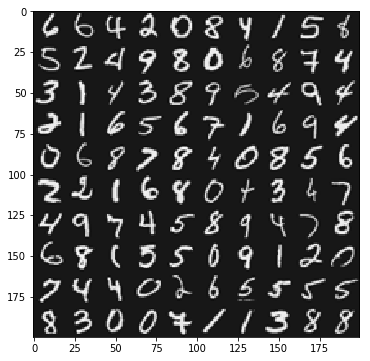

In [4]:
displayData()

#### 1.3 Vectorizing Logistic Regression

In [5]:
from scipy.special import expit
"""
Hypothesis function and cost function for logistic regression
"""
def h(mytheta, myX):
    return expit(np.dot(myX, mytheta))
def computeCost(mytheta, myX, myy, mylambda=0.):
    m = myX.shape[0]
    myh = h(mytheta, myX)  
    term1 = np.log(myh).dot(-myy.T)  
    term2 = np.log(1.0-myh).dot(1-myy.T)  
    left_hand = (term1-term2)/m  
    right_hand = mytheta.T.dot(mytheta)*mylambda/(2*m)  # (1, 1)
    return left_hand + right_hand 

#### 1.4 One-vs-all classification

In [6]:
def costGradient(mytheta, myX, myy, mylambda=0.):
    m = myX.shape[0]
    beta = h(mytheta, myX)-myy.T
    regterm = mytheta[1:]*(mylambda/m)
    grad = (1./m)*np.dot(myX.T, beta)
    grad[1:] = grad[1:] + regterm
    return grad

In [7]:
from scipy import optimize
def optimizeTheta(mytheta, myX, myy, mylambda=0.):
    result = optimize.fmin_cg(computeCost, fprime=costGradient, x0=mytheta, args=(myX, myy, mylambda), maxiter=50, disp=False, full_output=True)
    return result[0], result[1]

In [8]:
def buildTheta():
    mylambda = 0.
    initial_theta = np.zeros((X.shape[1], 1)).reshape(-1)
    Theta = np.zeros((10, X.shape[1]))
    for i in range(10):
        iclass = i if i else 10
        print('Optimizing for handwritten number %d...'%i)
        logic_y = np.array([1 if x==iclass else 0 for x in y])
        itheta, imincost = optimizeTheta(initial_theta, X, logic_y, mylambda)
        Theta[i, :] = itheta
    print('Done!')
    return Theta

In [9]:
Theta = buildTheta()

Optimizing for handwritten number 0...
Optimizing for handwritten number 1...
Optimizing for handwritten number 2...
Optimizing for handwritten number 3...
Optimizing for handwritten number 4...
Optimizing for handwritten number 5...
Optimizing for handwritten number 6...
Optimizing for handwritten number 7...
Optimizing for handwritten number 8...
Optimizing for handwritten number 9...
Done!


In [10]:
def predictOneVsAll(myTheta, myrow):
    """
    Function that computes a hypothesis for an individual image(row in X)
    and returns the predicted integer corresponding to the handwritten image
    """
    classes = [10] + list(range(1, 10))
    hypots = [0]*len(classes)
    for i in range(len(classes)):
        hypots[i] = h(myTheta[i], myrow)
    return classes[np.argmax(np.array(hypots))]

In [11]:
n_correct, n_total = 0., 0.
incorrect_indices = []
for irow in range(X.shape[0]):
    n_total += 1
    if predictOneVsAll(Theta, X[irow]) == y[irow]:
        n_correct += 1
    else: incorrect_indices.append(irow)
print('Training set accuracy: %0.1f%%' %(100*(n_correct/n_total)))

Training set accuracy: 85.4%


### 2 Nerual Networks

#### 2.1 Model representation

In [12]:
mat = spio.loadmat('ex3weights.mat')
Theta1, Theta2 = mat['Theta1'], mat['Theta2']
print('Theta1 has shape: ', Theta1.shape)
print('Theta2 has shape: ', Theta2.shape)

Theta1 has shape:  (25, 401)
Theta2 has shape:  (10, 26)


#### 2.2 Feadforword Propagation

In [14]:
def propagateForward(row, Thetas):
    """
    Function that given a list of Theatas, propagates the Row of features forwards,
    assuming the features already inlcude the bias unit in the input layer, and the
    Theatas need the bias unit added to features between each layer
    """
    features = row
    for i in range(len(Thetas)):
        Theta = Thetas[i]
        z = Theta.dot(features)
        a = expit(z)
        if i == len(Thetas)-1:
            return a
        a = np.insert(a, 0, 1)
        features = a
    
def predictNN(row, Thetas):
    classes = list(range(1, 10))+[10]
    output = propagateForward(row, Thetas)
    return classes[np.argmax(np.array(output))]
myThetas = [Theta1, Theta2]
n_correct, n_total = 0., 0.
incorrect_indices = []
for irow in range(X.shape[0]):
    n_total += 1
    if predictNN(X[irow], myThetas)==int(y[irow]):
        n_correct += 1
    else:
        incorrect_indices.append(irow)
print('Training set accuracy: %0.1f%%' %(100*(n_correct/n_total)) )

Training set accuracy: 87.6%
